# Solow-Growth Model
The following code is a toy model simulation of the Solow-Growth Model. According to this model, we would expect our model economy to settle at some steady-state output per worker (assuming no tech. progress). We expect this to occur once depreciation per worker equals savings per worker: $$\frac{δK}{N}=\frac{sY}{N}$$

# Setup
This model is made up of two entities: firms and workers. Programatically, they are represented as objects with the following relevant variables:

## Firms
At the start, the program will initialize a certain number of firms. The characteristics of each firm will depend on the following global variables:
1. *mean_employment*: this is the average number of workers in a firm. Each individual firm can deviate from this mean by at most the *model_temperature_percentage*. The sum of the employment of all of the firms is equal to $N$
2. *mean_initial_capital_usd*: this is the average capital that each firm have at the start. Each individual firm can deviate from this mean by at most the *model_temperature_percentage*. The sum of this is equal to $K$
3. *productivity*: Total Factor Productivity
4. *depreciation_rate*: a misnamed variable that i am afraid to touch at risk of messing up the code. This is actually equivalent to $(1-δ)$ where delta is the depreciation rate that we all know and love
5. *number_of_firms*: The number of firms to be modeled.

## Workers
At the start, each firm will initialize a certain number of workers. Each worker will have the following characteristics:
1. *marginal_propensity_to_consume*: The percentage of the worker's wage which will be used for consumption. More relevantly, if we let this to equal $c_1$ then the savings rate is $1-c_1$ which will be channeled to investment
2. *wage*: this program assumes that each worker gets paid their share of the company's output. i.e $$\text{wage}=\frac{Y_\text{firm}}{N_\text{firm}}$$

## Monthly Iteration
Each month, the following things happen:

### Phase 1: Production
During this phase, the firms produce based on the following production function:
$$Y_\text{firm}=A\cdot K^{0.5}\cdot L^{0.5}$$
During this phase, we also depreciate our capital using the following formula
$$K_{t+1}=K_t\cdot (1-δ)$$

### Phase 2: Pay Workers
During this phase, we pay each worker their wages using the ff formula:$$\text{wage}=\frac{Y_\text{firm}}{N_\text{firm}}$$

### Phase 3: Consumption
During this phase, each workers 'consume'. In code though, we only care about the relevant savings as a result of this consumption. For each worker we have the following savings: $$S_\text{worker}=\frac{Y_\text{firm}}{N_\text{firm}}\cdot (1-c_1)$$
We then pool all the savings into the global variable *total_savings* as a sum of each worker's savings
$$S_\text{total} = \sum_{i}^{N}S_i$$

### Phase 4: Investment
During this phase, each firm takes from the pool of savings and uses it to invest (i.e. increase their capital). The amount that each firm gets depends on their level of output:
$$I = S_\text{total} \cdot \left(\frac{Y_\text{firm}}{Y_\text{total}}\right)$$

# Simulation 1
Here, the initial capital is less than the steady state. Notice how $\frac{Y}{N}$ starts low and rises until the level where depreciation and savings intersect, then the economy stays at that level.

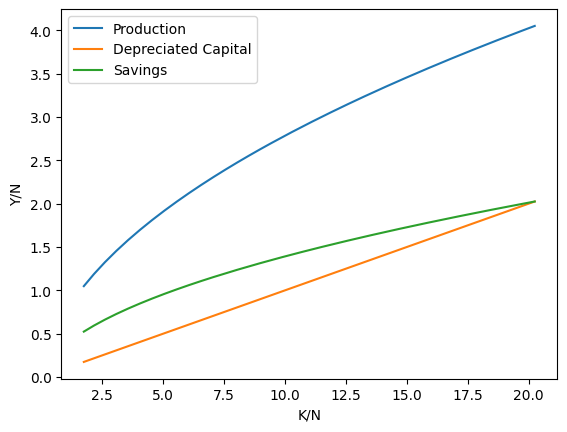

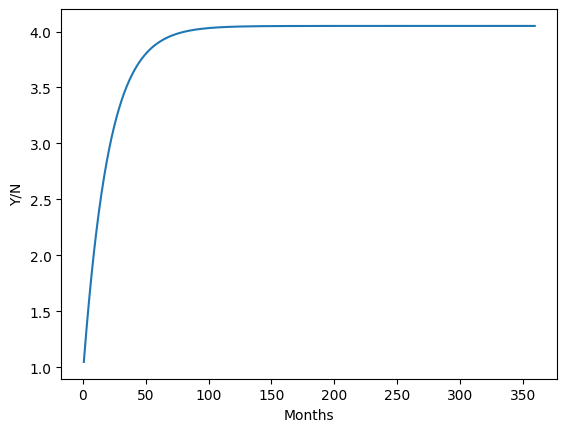

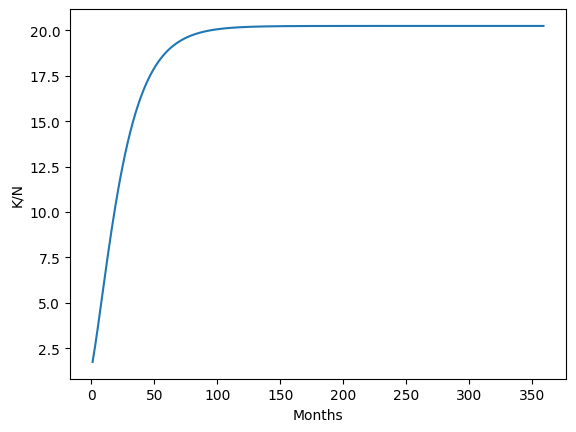

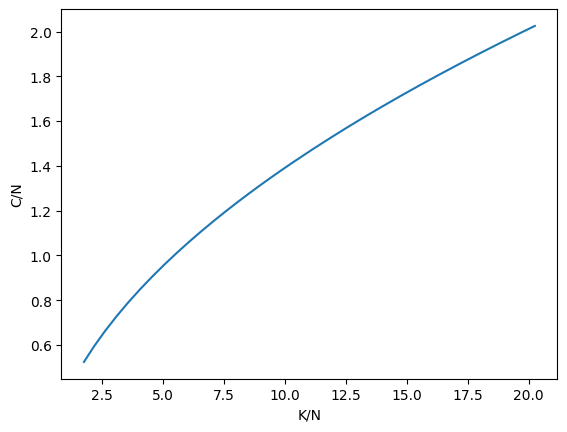

In [3]:
'''
Variables you can change
'''
#variability
model_temperature_percentage = 10

#FirmVariables
mean_employment = 20
mean_initial_capital_usd = 20
productivity = 0.9
depreciation_rate = 0.90
number_of_firms = 40

#WorkerVariables
marginal_propensity_to_consume = 0.5

#GlobalVariables
total_capital = 0
total_output = 0
total_savings = 0
total_workers = 0
total_consumption = 0


'''
Code
'''
#import random
import math
import random
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

class Worker:
    global total_savings, marginal_propensity_to_consume

    def __init__(self):
        self.mpc = marginal_propensity_to_consume

    def pay(self, wage):
        self.wage = wage

    def buy(self, price):
        global total_savings, total_consumption
        total_savings += self.wage * (1-self.mpc)
        total_consumption += self.wage * self.mpc


class Firm:
    global total_output, total_savings, mean_employment, mean_initial_capital_usd, productivity, markup, depreciation_rate
    def __init__(self):
        self.workers = []
        self.employment = max(mean_employment + random.randint(-mean_employment // model_temperature_percentage, mean_employment // model_temperature_percentage),1)
        self.initial_capital_usd = max(mean_initial_capital_usd + random.randint(-mean_initial_capital_usd // model_temperature_percentage, mean_initial_capital_usd // model_temperature_percentage),1)
        self.productivity = productivity

    def setup_workers(self):
        global total_workers
        for i in range(self.employment):
            total_workers += 1
            worker = Worker()
            self.workers.append(worker)

    def produce(self):
        global total_output

        #produce based on the production function
        self.output = self.productivity * math.sqrt(self.initial_capital_usd) *math.sqrt(self.employment)
        total_output+= self.output

        #depreciate equipment
        self.initial_capital_usd = self.initial_capital_usd * depreciation_rate

    def invest(self):
        global total_output, total_savings
        #get investment proportional to the amount of output you have
        self.initial_capital_usd += total_savings * (self.output/total_output)

    def consume(self, price):
        for worker in self.workers:
            worker.buy(price)

    def pay_workers(self):
        for worker in self.workers:
            worker.pay(self.output/self.employment)


target_months = 12*30
months = 0



x=[]
y=[]
y2=[]
time = []
c = []
#initialize firms
firms = []
for i in range(number_of_firms):
  firm = Firm()
  firm.setup_workers()
  firms.append(firm)

#Simulate months
while months < target_months:
  total_output = 0
  total_savings = 0
  total_consumption = 0

  #total capital is set to 0 here momentarily, but is recalculated again (thus, flow variable)
  total_capital = 0
  for firm in firms:
    #production
    firm.produce()
    firm.pay_workers()

    #consumption
    firm.consume(firm.output)

    #reinvestment
    firm.invest()

    #calculate
    total_capital += firm.initial_capital_usd


  x.append(total_capital/total_workers)
  y.append(total_output/total_workers)
  y2.append(total_savings/total_workers)
  c.append(total_consumption/total_workers)
  time.append(months)

  months += 1


#Plotting
x.pop(0)
y.pop(0)
y2.pop(0)
c.pop(0)
time.pop(0)

plt.plot(x,y, label = "Production")
plt.xlabel("K/N")
dep = []
for i in x:
  dep.append((1-depreciation_rate)*i)
plt.plot(x,dep, label = "Depreciated Capital")
plt.plot(x,y2, label = "Savings")
plt.ylabel("Y/N")
plt.legend()
plt.show()

plt.plot(time,y)
plt.xlabel("Months")
plt.ylabel("Y/N")
plt.show()

plt.plot(time,x)
plt.xlabel("Months")
plt.ylabel("K/N")
plt.show()

plt.plot(x,c)
plt.xlabel("K/N")
plt.ylabel("C/N")
plt.show()

# Simulation 2
Here, the initial capital is more than the steady state. Notice how $\frac{Y}{N}$ starts high and high until the level where depreciation and savings intersect, then the economy stays at that level.

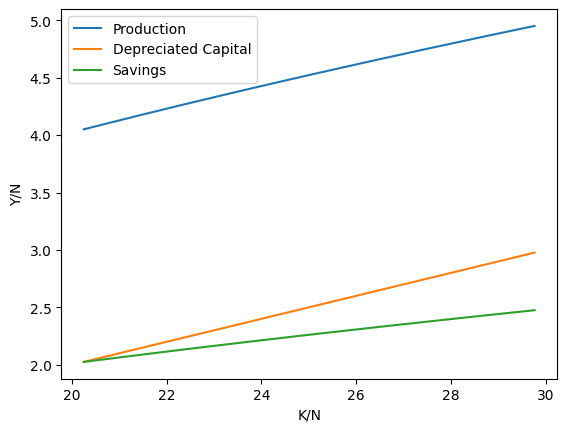

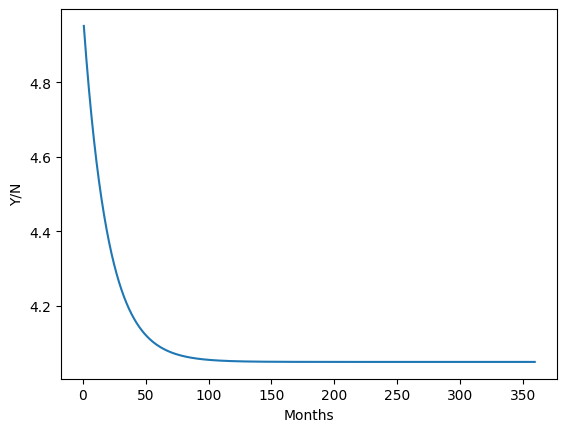

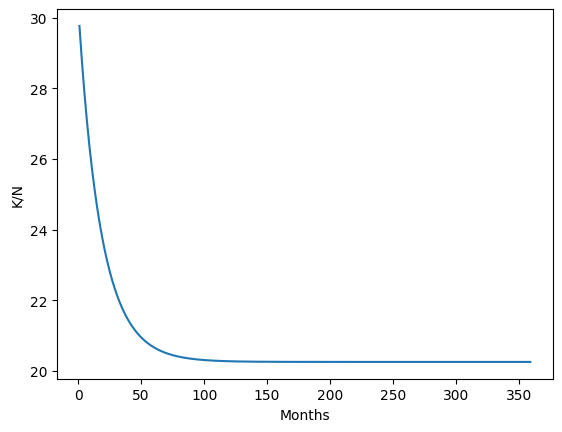

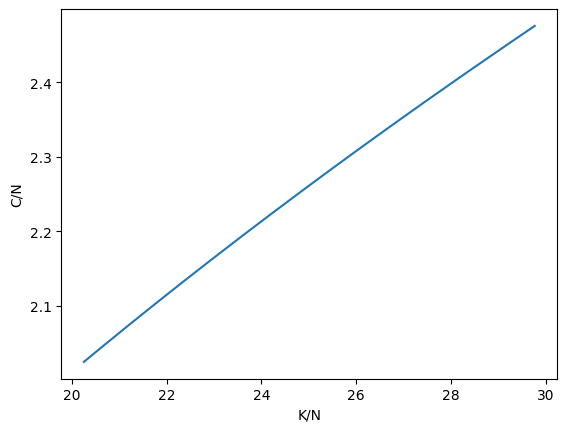

In [7]:
'''
Variables you can change
'''
#variability
model_temperature_percentage = 10

#FirmVariables
mean_employment = 20
mean_initial_capital_usd = 600
productivity = 0.9
depreciation_rate = 0.90
number_of_firms = 40

#WorkerVariables
marginal_propensity_to_consume = 0.5

#GlobalVariables
total_capital = 0
total_output = 0
total_savings = 0
total_workers = 0
total_consumption = 0


'''
Code
'''
#import random
import math
import random
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

class Worker:
    global total_savings, marginal_propensity_to_consume

    def __init__(self):
        self.mpc = marginal_propensity_to_consume

    def pay(self, wage):
        self.wage = wage

    def buy(self, price):
        global total_savings, total_consumption
        total_savings += self.wage * (1-self.mpc)
        total_consumption += self.wage * self.mpc


class Firm:
    global total_output, total_savings, mean_employment, mean_initial_capital_usd, productivity, markup, depreciation_rate
    def __init__(self):
        self.workers = []
        self.employment = max(mean_employment + random.randint(-mean_employment // model_temperature_percentage, mean_employment // model_temperature_percentage),1)
        self.initial_capital_usd = max(mean_initial_capital_usd + random.randint(-mean_initial_capital_usd // model_temperature_percentage, mean_initial_capital_usd // model_temperature_percentage),1)
        self.productivity = productivity

    def setup_workers(self):
        global total_workers
        for i in range(self.employment):
            total_workers += 1
            worker = Worker()
            self.workers.append(worker)

    def produce(self):
        global total_output

        #produce based on the production function
        self.output = self.productivity * math.sqrt(self.initial_capital_usd) *math.sqrt(self.employment)
        total_output+= self.output

        #depreciate equipment
        self.initial_capital_usd = self.initial_capital_usd * depreciation_rate

    def invest(self):
        global total_output, total_savings
        #get investment proportional to the amount of output you have
        self.initial_capital_usd += total_savings * (self.output/total_output)

    def consume(self, price):
        for worker in self.workers:
            worker.buy(price)

    def pay_workers(self):
        for worker in self.workers:
            worker.pay(self.output/self.employment)


target_months = 12*30
months = 0



x=[]
y=[]
y2=[]
time = []
c = []
#initialize firms
firms = []
for i in range(number_of_firms):
  firm = Firm()
  firm.setup_workers()
  firms.append(firm)

#Simulate months
while months < target_months:
  total_output = 0
  total_savings = 0
  total_consumption = 0

  #total capital is set to 0 here momentarily, but is recalculated again (thus, flow variable)
  total_capital = 0
  for firm in firms:
    #production
    firm.produce()
    firm.pay_workers()

    #consumption
    firm.consume(firm.output)

    #reinvestment
    firm.invest()

    #calculate
    total_capital += firm.initial_capital_usd


  x.append(total_capital/total_workers)
  y.append(total_output/total_workers)
  y2.append(total_savings/total_workers)
  c.append(total_consumption/total_workers)
  time.append(months)

  months += 1


#Plotting
x.pop(0)
y.pop(0)
y2.pop(0)
c.pop(0)
time.pop(0)

plt.plot(x,y, label = "Production")
plt.xlabel("K/N")
dep = []
for i in x:
  dep.append((1-depreciation_rate)*i)
plt.plot(x,dep, label = "Depreciated Capital")
plt.plot(x,y2, label = "Savings")
plt.ylabel("Y/N")
plt.legend()
plt.show()

plt.plot(time,y)
plt.xlabel("Months")
plt.ylabel("Y/N")
plt.show()

plt.plot(time,x)
plt.xlabel("Months")
plt.ylabel("K/N")
plt.show()

plt.plot(x,c)
plt.xlabel("K/N")
plt.ylabel("C/N")
plt.show()

# Simulation 3
Here, the initial capital is roughly equal to the steady state. Notice how $\frac{Y}{N}$ does not change much as time goes on.

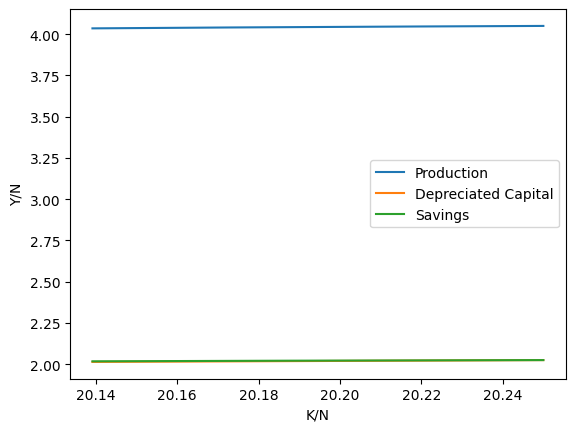

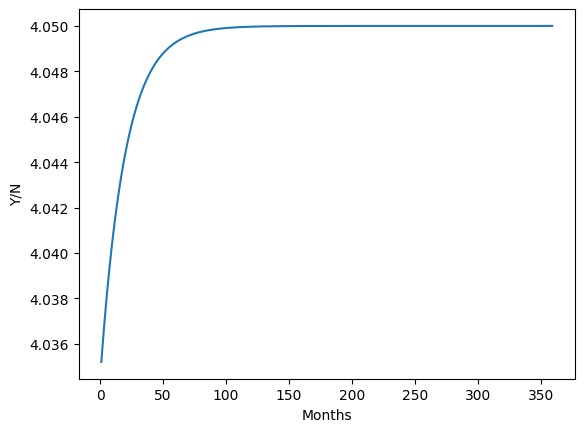

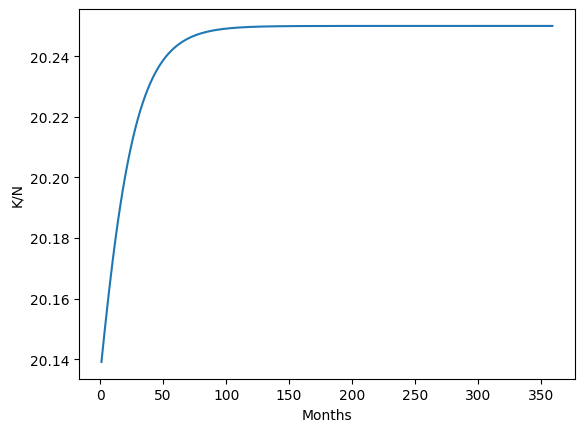

In [ ]:
'''
Variables you can change
'''
#variability
model_temperature_percentage = 10

#FirmVariables
mean_employment = 20
mean_initial_capital_usd = 400
productivity = 0.9
depreciation_rate = 0.90
number_of_firms = 40

#WorkerVariables
marginal_propensity_to_consume = 0.5

#GlobalVariables
total_capital = 0
total_output = 0
total_savings = 0
total_workers = 0



'''
Code
'''
#import random
import math
import random
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

class Worker:
    global total_savings, marginal_propensity_to_consume

    def __init__(self):
        self.mpc = marginal_propensity_to_consume

    def pay(self, wage):
        self.wage = wage

    def buy(self, price):
        global total_savings
        total_savings += self.wage * (1-self.mpc)


class Firm:
    global total_output, total_savings, mean_employment, mean_initial_capital_usd, productivity, markup, depreciation_rate
    def __init__(self):
        self.workers = []
        self.employment = max(mean_employment + random.randint(-mean_employment // model_temperature_percentage, mean_employment // model_temperature_percentage),1)
        self.initial_capital_usd = max(mean_initial_capital_usd + random.randint(-mean_initial_capital_usd // model_temperature_percentage, mean_initial_capital_usd // model_temperature_percentage),1)
        self.productivity = productivity

    def setup_workers(self):
        global total_workers
        for i in range(self.employment):
            total_workers += 1
            worker = Worker()
            self.workers.append(worker)

    def produce(self):
        global total_output

        #produce based on the production function
        self.output = self.productivity * math.sqrt(self.initial_capital_usd) *math.sqrt(self.employment)
        total_output+= self.output

        #depreciate equipment
        self.initial_capital_usd = self.initial_capital_usd * depreciation_rate

    def invest(self):
        global total_output, total_savings
        #get investment proportional to the amount of output you have
        self.initial_capital_usd += total_savings * (self.output/total_output)

    def consume(self, price):
        for worker in self.workers:
            worker.buy(price)

    def pay_workers(self):
        for worker in self.workers:
            worker.pay(self.output/self.employment)


target_months = 12*30
months = 0



x=[]
y=[]
y2=[]
time = []
#initialize firms
firms = []
for i in range(number_of_firms):
  firm = Firm()
  firm.setup_workers()
  firms.append(firm)

#Simulate months
while months < target_months:
  total_output = 0
  total_savings = 0

  #total capital is set to 0 here momentarily, but is recalculated again (thus, flow variable)
  total_capital = 0
  for firm in firms:
    #production
    firm.produce()
    firm.pay_workers()

    #consumption
    firm.consume(firm.output)

    #reinvestment
    firm.invest()

    #calculate
    total_capital += firm.initial_capital_usd


  x.append(total_capital/total_workers)
  y.append(total_output/total_workers)
  y2.append(total_savings/total_workers)
  time.append(months)

  months += 1


#Plotting
x.pop(0)
y.pop(0)
y2.pop(0)
time.pop(0)

plt.plot(x,y, label = "Production")
plt.xlabel("K/N")
dep = []
for i in x:
  dep.append((1-depreciation_rate)*i)
plt.plot(x,dep, label = "Depreciated Capital")
plt.plot(x,y2, label = "Savings")
plt.ylabel("Y/N")
plt.legend()
plt.show()

plt.plot(time,y)
plt.xlabel("Months")
plt.ylabel("Y/N")
plt.show()

plt.plot(time,x)
plt.xlabel("Months")
plt.ylabel("K/N")
plt.show()

# Simulation 4
Here we include productivity growth. It doesn't work fully as expected due to limitations in the developer's skills in both programming and economics, but you can see the output per worker is no longer stagnant.

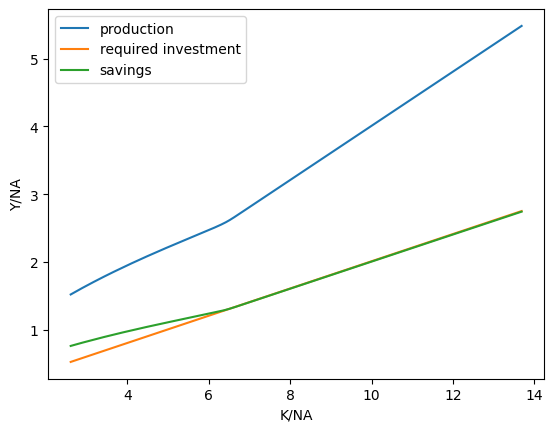

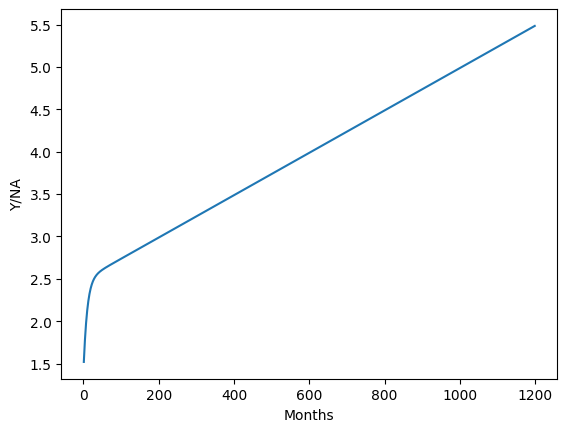

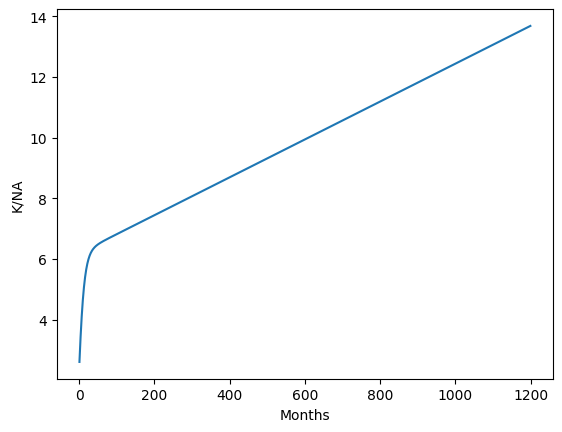

In [ ]:
'''
Variables you can change
'''

#FirmVariables
mean_employment = 10
mean_initial_capital_usd = 20
productivity = 1
depreciation_rate = 0.80

#tech progress
productivity_growth = 0.001

#WorkerVariables
marginal_propensity_to_consume = 0.5

#GlobalVariables
total_capital = 0
total_output = 0
total_savings = 0
total_workers = 0


'''
Code
'''
#import random
import math
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

class Worker:
    global total_savings, marginal_propensity_to_consume

    def __init__(self):
        self.mpc = marginal_propensity_to_consume

    def pay(self, wage):
        self.wage = wage

    def buy(self, price):
        global total_savings
        total_savings += self.wage * (1-self.mpc)


class Firm:
    global total_output, total_savings, mean_employment, mean_initial_capital_usd, productivity, markup, depreciation_rate
    def __init__(self):
        self.workers = []
        self.employment = mean_employment
        self.initial_capital_usd = mean_initial_capital_usd
        self.productivity = productivity

    def setup_workers(self):
        global total_workers
        for i in range(self.employment):
            total_workers += 1
            worker = Worker()
            self.workers.append(worker)

    def produce(self):
        global total_output

        #produce based on the production function
        self.output = math.sqrt(self.initial_capital_usd) * math.sqrt(self.employment * self.productivity)
        total_output+= self.output

        #depreciate equipment
        self.initial_capital_usd = self.initial_capital_usd * depreciation_rate

    def invest(self):
        global total_output, total_savings
        #get investment proportional to the amount of output you have
        self.initial_capital_usd += total_savings * (self.output/total_output)

    def consume(self, price):
        for worker in self.workers:
            worker.buy(price)

    def pay_workers(self):
        for worker in self.workers:
            worker.pay(self.output/self.employment)

target_months = 12 * 100
months = 0

number_of_firms = 30

x=[]
y=[]
y2=[]
time = []
#initialize firms
firms = []
for i in range(number_of_firms):
  firm = Firm()
  firm.setup_workers()
  firms.append(firm)

#Simulate months
while months < target_months:
  total_output = 0
  total_savings = 0

  #total capital is set to 0 here momentarily, but is recalculated again (thus, flow variable)
  total_capital = 0
  for firm in firms:
    #production
    firm.produce()
    firm.pay_workers()

    #consumption
    firm.consume(firm.output)

    #reinvestment
    firm.invest()

    #calculate
    total_capital += firm.initial_capital_usd


  x.append(total_capital/(total_workers*productivity))
  y.append(total_output/(total_workers*productivity))
  y2.append(total_savings/(total_workers*productivity))
  time.append(months)

  #Innovate
  for firm in firms:
    firm.productivity += productivity_growth

  months += 1


#Plotting
x.pop(0)
y.pop(0)
y2.pop(0)
time.pop(0)

plt.plot(x,y, label = "production")
plt.xlabel("K/NA")
dep = []
for i in x:
  dep.append(((1-depreciation_rate)+productivity_growth)*i)
plt.plot(x,dep, label = "required investment")
plt.plot(x,y2, label = "savings")
plt.ylabel("Y/NA")
plt.legend()
plt.show()

plt.plot(time,y)
plt.xlabel("Months")
plt.ylabel("Y/NA")
plt.show()

plt.plot(time,x)
plt.xlabel("Months")
plt.ylabel("K/NA")
plt.show()

# Simulation 5
Here we include productivity growth. But we allocate it to Total Factor Productivity instead of Labor Productivity

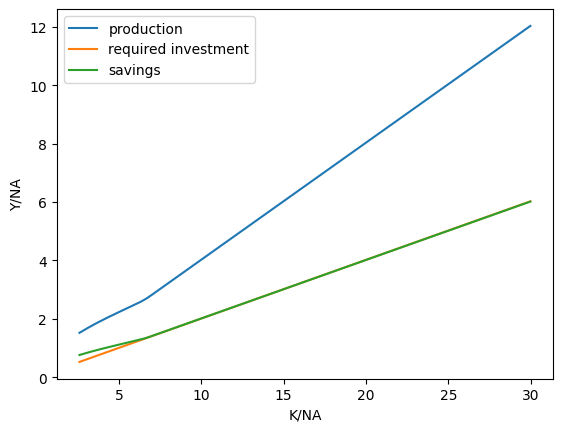

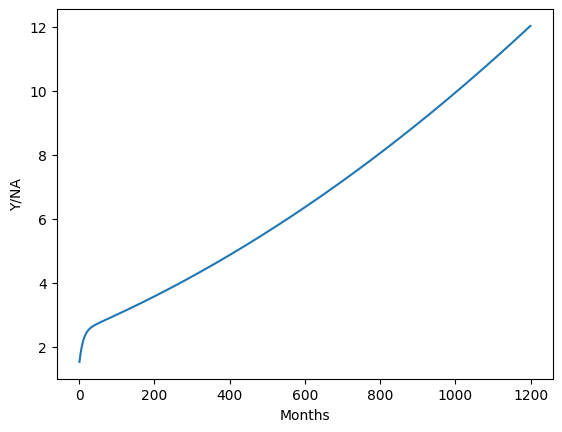

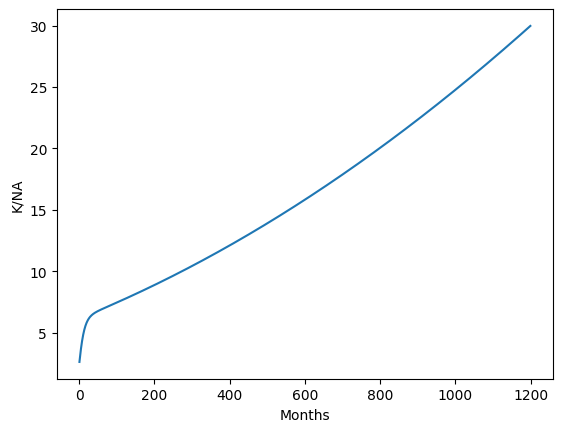

In [1]:
'''
Variables you can change
'''

#FirmVariables
mean_employment = 10
mean_initial_capital_usd = 20
productivity = 1
depreciation_rate = 0.80

#tech progress
productivity_growth = 0.001

#WorkerVariables
marginal_propensity_to_consume = 0.5

#GlobalVariables
total_capital = 0
total_output = 0
total_savings = 0
total_workers = 0


'''
Code
'''
#import random
import math
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

class Worker:
    global total_savings, marginal_propensity_to_consume

    def __init__(self):
        self.mpc = marginal_propensity_to_consume

    def pay(self, wage):
        self.wage = wage

    def buy(self, price):
        global total_savings
        total_savings += self.wage * (1-self.mpc)


class Firm:
    global total_output, total_savings, mean_employment, mean_initial_capital_usd, productivity, markup, depreciation_rate
    def __init__(self):
        self.workers = []
        self.employment = mean_employment
        self.initial_capital_usd = mean_initial_capital_usd
        self.productivity = productivity

    def setup_workers(self):
        global total_workers
        for i in range(self.employment):
            total_workers += 1
            worker = Worker()
            self.workers.append(worker)

    def produce(self):
        global total_output

        #produce based on the production function
        self.output = self.productivity * math.sqrt(self.initial_capital_usd) * math.sqrt(self.employment)
        total_output+= self.output

        #depreciate equipment
        self.initial_capital_usd = self.initial_capital_usd * depreciation_rate

    def invest(self):
        global total_output, total_savings
        #get investment proportional to the amount of output you have
        self.initial_capital_usd += total_savings * (self.output/total_output)

    def consume(self, price):
        for worker in self.workers:
            worker.buy(price)

    def pay_workers(self):
        for worker in self.workers:
            worker.pay(self.output/self.employment)

target_months = 12 * 100
months = 0

number_of_firms = 30

x=[]
y=[]
y2=[]
time = []
#initialize firms
firms = []
for i in range(number_of_firms):
  firm = Firm()
  firm.setup_workers()
  firms.append(firm)

#Simulate months
while months < target_months:
  total_output = 0
  total_savings = 0

  #total capital is set to 0 here momentarily, but is recalculated again (thus, flow variable)
  total_capital = 0
  for firm in firms:
    #production
    firm.produce()
    firm.pay_workers()

    #consumption
    firm.consume(firm.output)

    #reinvestment
    firm.invest()

    #calculate
    total_capital += firm.initial_capital_usd


  x.append(total_capital/(total_workers*productivity))
  y.append(total_output/(total_workers*productivity))
  y2.append(total_savings/(total_workers*productivity))
  time.append(months)

  #Innovate
  for firm in firms:
    firm.productivity += productivity_growth

  months += 1


#Plotting
x.pop(0)
y.pop(0)
y2.pop(0)
time.pop(0)

plt.plot(x,y, label = "production")
plt.xlabel("K/NA")
dep = []
for i in x:
  dep.append(((1-depreciation_rate)+productivity_growth)*i)
plt.plot(x,dep, label = "required investment")
plt.plot(x,y2, label = "savings")
plt.ylabel("Y/NA")
plt.legend()
plt.show()

plt.plot(time,y)
plt.xlabel("Months")
plt.ylabel("Y/NA")
plt.show()

plt.plot(time,x)
plt.xlabel("Months")
plt.ylabel("K/NA")
plt.show()